<a href="https://colab.research.google.com/github/tsteifer/transformers-for-triangle-free-graphs/blob/main/Triangle_freeness_testing_with_generalized_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ModuleList, LayerNorm, Dropout, CrossEntropyLoss
import numpy as np
import einops
import tqdm.notebook as tqdm

import math


import random
import time
import copy

#from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
#%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'
import plotly.graph_objects as go
from plotly import subplots

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

import re

# import comet_ml
import itertools

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root=os.path

# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []

    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name

    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output,
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")

    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")

    def forward(self, x):
        return x

# Define network architecture
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PositionalEncoding1(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()

        pe = torch.zeros(max_len*max_len, d_model)
        #position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 4*torch.exp(torch.arange(d_model/4,).float() * (-math.log(10000.0) / d_model)).unsqueeze(0)
        pos=torch.tensor(np.indices((max_len,max_len)).flatten()).unsqueeze(1)
        #pos=torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        pe[:, 0::4] = torch.sin(pos[:max_len**2] * div_term)#.unsqueeze(1)
        pe[:, 1::4] = torch.cos(pos[:max_len**2] * div_term)#.unsqueeze(1)
        pe[:, 2::4] = torch.sin(pos[max_len**2:] * div_term)#.unsqueeze(0)
        pe[:, 3::4] = torch.cos(pos[max_len**2:] * div_term)#.unsqueeze(0)
        # plt.imshow(pe)
        # plt.show()
        pe=pe.view((max_len*max_len,d_model)).unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #print(x.size())
        #print(self.pe.size())
        x = x + self.pe[:,:, :]
        return x#self.dropout(x)


class PositionalEncoding0(nn.Module):

    def __init__(self, sqn, max_len=20):
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)
        max_len=sqn**2
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #pe=pe.view(())
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.size(1), :]
        return x#self.dropout(x)

class PosEmbed2D(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()
        sqn=int(np.sqrt(max_len))
        self.peX = nn.Parameter(torch.randn(sqn,d_model))
        self.peY = nn.Parameter(torch.randn(sqn,d_model))
        position = torch.tensor(np.indices((sqn,sqn)))
        position = position.view((2,sqn**2))
        # print(self.peX.size())
        # print(position.size())
        self.register_buffer('position',position)


    def forward(self, x):
        # print(x.size())

        x = x + self.peX[self.position[0,:],:].unsqueeze(0)
        x = x + self.peY[self.position[1,:],:].unsqueeze(0)
        return x#self.dropout(x)

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()
        self.hook_k2 = HookPoint()
        self.hook_q2 = HookPoint()
        self.hook_v2 = HookPoint()
        self.hook_z2 = HookPoint()
        self.hook_attn2 = HookPoint()
        self.hook_attn_pre2 = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
       # attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_pre/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out



class EdgeAttentionEncoder(nn.Module):
    def __init__(self,d_model, num_heads,model):
        super().__init__()
        # We assume d_v always equals d_k
        self.model = model
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.linears = _get_clones(nn.Linear(d_model, d_model), 5)
        self.reduce_dim_key = nn.Linear(2*d_model,d_model)
        self.reduce_dim_value = nn.Linear(2*d_model,d_model)
        self.attn = None

    def forward(self, state, mask=None):
        num_batches = state.size(0)
        num_nodes = int(np.sqrt(state.size(1)))
        device = state.device
        state=state.view(num_batches,num_nodes,num_nodes,self.d_model)
        query, key, value = state, state, state



        left_k, right_k, left_v, right_v = [l(x) for l, x in zip(self.linears, (key, key, value, value))]
        left_k = left_k.view(num_batches, num_nodes, num_nodes, self.num_heads, self.d_k)
        right_k = right_k.view_as(left_k)
        left_v = left_v.view_as(left_k)
        right_v = right_v.view_as(left_k)

        scores = torch.einsum("bxahd,bayhd->bxayh",left_k,right_k) / math.sqrt(self.d_k)


        val = torch.einsum("bxahd,bayhd->bxayhd",left_v,right_v)

        att = F.softmax(scores,dim=2)


        x = torch.einsum("bxayh,bxayhd->bxyhd",att,val)
        x = x.view(num_batches,num_nodes*num_nodes,self.d_model)
        return self.linears[-1](x)

def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, edge_mode, model):
        super().__init__()
        self.model = model
        self.ln1 = LayerNorm(d_model, model=self.model)
        if edge_mode:
            self.attn = EdgeAttentionEncoder(d_model, num_heads,model=self.model)
        else:
            self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        #self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()

    def forward(self, x):
        x = self.hook_resid_mid(self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(self.hook_mlp_out(self.mlp((x))))
        # x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        # x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x



# Full transformer
class Transformer(nn.Module):
    def __init__(self, sqn, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False,use_ln=True, edge_mode=False):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PositionalEncoding0(d_model,sqn)
        #self.pos_embed = PosEmbed2D(d_model,n_ctx)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, edge_mode, model=[self]) for i in range(num_layers)])
        self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')

    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    logprobs.size()
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss



def full_loss(model, data):
    global p
    # Take the final position only
    logits = model([i[0] for i in data])[:, -p]
    labels = torch.tensor([i[1] for i in data])#.to('cuda')
    return cross_entropy_high_precision(logits, labels)

def triangle_free(adj):
    sqn=np.shape(adj)[0]
    for a in range(sqn):
        for b in range(sqn):
            if adj[a,b]==1 and not(a==b):
                for c in range(sqn):
                    if not(a==c) and not(b==c):
                        if adj[b,c]==1 and adj[a,c]==1:
                            return 0#False
    return 1#True
    #return int(np.trace(np.dot(np.dot(adj,adj),adj))==0)

def flatten(adj):
    #print(np.shape(adj))
    #print(len(adj[np.tril_indices(np.shape(adj)[0],-1)]))
    return adj.reshape((np.shape(adj)[0]*np.shape(adj)[1]))
    #return adj[np.tril_indices(np.shape(adj)[0],-1)]


def gen_train_test(num,size, mu=2):
    data=[]
    sqn=int(np.sqrt(num))
    n=int(sqn/3)
    inds=np.arange(sqn)
    for k in range(mu):
        for sample in range(500):
            adj=np.zeros((sqn,sqn))
            #inds=np.arange(sqn)
            np.random.shuffle(inds)
            p=1/2
            for i in range(n):
                for j in range(n):
                    adj[inds[i],inds[j+n]]=random.choices([0,1],[1-p,p],k=1)[0]
                    adj[inds[i],inds[j+2*n]]=random.choices([0,1],[1-p,p],k=1)[0]
                    adj[inds[i+n],inds[j+2*n]]=random.choices([0,1],[1-p,p],k=1)[0]
            adj=np.tril(adj.T,-1) + np.triu(adj, 1)
            adj[np.diag_indices_from(adj)]=0
            x=flatten(adj)
            y=triangle_free(adj)
            data.append([x,y])
    return data

lr=1e-3 #@param
weight_decay =  1e-3 #@param
nodes=9
p=nodes*nodes

num_epochs = 2000 #@param
save_models = False #@param
save_every = 100 #@param

seed = 0 #@param
d_vocab = 2
n_ctx = p

d_model = 32
num_layers = 2
d_mlp = 4*d_model
num_heads = 1
assert d_model % num_heads == 0
d_head = d_model//num_heads

act_type = 'ReLU' #@param ['ReLU', 'GeLU']


def executeTraining(d_model,num_layers,edgeMode):
    c=0.
    for k in range(len(train)):
        if train[k][1]==1:
            c+=1
    c=c/len(test)
    print('Start')
    model = Transformer(sqn=int(np.sqrt(p)),num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False,edge_mode=edgeMode)
    #model.to('cuda')
    print('Model defined')
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))#,amsgrad=True)
    #optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
    run_name = f"Att4Pairs_{int(time.time())}"
    lossFunction=torch.nn.BCEWithLogitsLoss()#weight=torch.zeros((32,1))+c)
    emp_losses=[]
    gen_losses=[]
    print(f'Run name {run_name}')
    if save_models:
        os.mkdir(run_name)
        save_dict = {'model':model.state_dict(), 'train_data':train, 'test_data':test}
        torch.save(save_dict, run_name+'/init.pth')
    for epoch in range(num_epochs):
        random.shuffle(train)
        for batch in range(int(len(train)/32.)):
            data=train[batch*32:(batch+1)*32]
            logits = model(np.array([i[0] for i in data]))[:, -1]
            #print(logits.size())
            logits=logits[:,0].to(torch.float64)
            #logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
            #logprobs = logits.to(torch.float64)
            #print(logprobs)
            labels = torch.tensor(np.array([i[1] for i in data]))#.to('cuda')
            labels=labels.to(torch.float64)
            #prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
            loss = lossFunction(logits,labels)
            #loss = -torch.mean(prediction_logprobs)
            #loss.requires_grad = True
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        if epoch%100 == 0: print(f"{epoch}_{np.log(loss.item())}")#_{train_acc.item():.4f}_{test_acc.item():.4f}")

        if epoch%100 == 0:
            err=0
            for example in train:
                pred=torch.round(F.sigmoid(model([example[0]])[:,-1][:,0]))
                err+=int(torch.sum(abs(torch.tensor(example[1])-pred)))
                #err+=int(torch.sum(abs(torch.tensor(example[1])-model([example[0]])[:,-int(p/2):].argmax(axis=-1))))
            print('Empirical error:_'+str(err/len(train)))
            emp_losses.append(err)
            err_gen=0
            for example in test:
                pred=torch.round(F.sigmoid(model([example[0]])[:,-1][:,0]))
                err_gen+=int(abs(example[1]-pred))
            print('Generalization error:_'+str(err_gen/len(test)))
            gen_losses.append(err_gen)


        if False:#epoch%100 == 0:
            err=0
            for batch in range(int(len(train)/32.)):
                data=train[batch*32:(batch+1)*32]
                data=np.array([i[0] for i in data])
                #print(data.shape)
                pred=model(data)[:,-1]#.argmax(axis=-1)
                #print(pred)
                pred = F.log_softmax(pred, dim=-1)#.argmax(axis=-1)
                pred=pred[:,0]
                labels = torch.tensor(np.array([i[1] for i in data]))#.to('cuda')

                #print(labels)
                err+=torch.sum(torch.abs(pred-labels))
            print('Empirical error:_'+str(err/len(train)))
            emp_losses.append(err/len(train))
            err_gen=0
            for batch in range(int(len(test)/32.)):
                data=np.array([i[0] for i in data])
                pred=model(data)[:,-1]#.argmax(axis=-1)
                #print(pred)
                pred = F.log_softmax(pred, dim=-1)#.argmax(axis=-1)
                pred=pred[:,0]
                labels = torch.tensor(np.array([i[1] for i in data]))#.to('cuda')
                labels=labels.to(torch.int64)
                err_gen+=torch.sum(torch.abs(pred-labels))
            print('Generalization error:_'+str(err_gen/len(test)))
            gen_losses.append(err_gen/len(test))
            # for example in train:
            #     err+=int(torch.sum(abs(torch.tensor(example[1])-model([example[0]])[:,-1].argmax())))
            # print('Empirical error:_'+str(err/len(train)))
            # emp_losses.append(err)
            # err_gen=0
            # for example in test:
            #     err_gen+=int(abs(example[1]-model([example[0]])[:,-1].argmax()))
            # print('Generalization error:_'+str(err_gen/len(test)))
            # gen_losses.append(err_gen)
    if not save_models:
        os.mkdir(run_name)
    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'loss': loss,
        'epoch': epoch,
    }
    torch.save(save_dict, run_name+'/'+f"final.pth")
    print(f"Done")
    plt.plot(emp_losses)
    plt.plot(gen_losses)
    plt.show()

train = gen_train_test(p, seed)
test = gen_train_test(p, seed)
print("How many triangle-free graphs in the sample?")
c=0.
for k in range(len(train)):
    if train[k][1]==1:
        c+=1
print(c/len(test))



How many triangle-free graphs in the sample?
0.661


In [55]:
def gen_random(num, seed=0, size=90000):
    data=[]
    sqn=int(np.sqrt(num))
    c=0
    for k in range(size):
        dat=random.choices([0,1],[0.9,0.1],k=num)
        dat=dat[:num]
        adj=np.array(dat)
        adj=adj.reshape((sqn,sqn))
        adj=np.tril(adj,-1) + np.triu(adj.T, 1)
        adj[np.diag_indices_from(adj)]=0
        data.append([flatten(adj),triangle_free(adj)])
    # while c<(size/1.1):
    #     dat=random.choices([0,1],k=num)
    #     dat=dat[:num]
    #     adj=np.array(dat)
    #     adj=adj.reshape((sqn,sqn))
    #     adj=np.tril(adj,-1) + np.triu(adj.T, 1)
    #     adj[np.diag_indices_from(adj)]=0
    #     label=triangle_free(adj)
    #     if label==1:
    #         data.append([flatten(adj),triangle_free(adj)])
    #         c+=1
    random.seed(seed)
    random.shuffle(data)
    return data

# train = gen_random(p, seed)
# test = gen_random(p, seed)
print("How many triangle-free graphs in the sample?")
c=0.
for k in range(len(train)):
    if train[k][1]==1:
        c+=1
print(c/len(test))

num_epochs = 2500 #@param
d_vocab=2

executeTraining(d_model,num_layers,edgeMode=True)

How many triangle-free graphs in the sample?
0.661
Start
Model defined
Run name Att4Pairs_1726414763
0_-0.608996492059738
Empirical error:_0.339
Generalization error:_0.35
100_-2.2264134751715785
Empirical error:_0.03
Generalization error:_0.12
200_-14.59988622968782
Empirical error:_0.0
Generalization error:_0.118
300_-23.6341114312184
Empirical error:_0.0
Generalization error:_0.12
400_-24.51579391068219
Empirical error:_0.0
Generalization error:_0.121


KeyboardInterrupt: 

In [ ]:
executeTraining(d_model,num_layers,edgeMode=True)

NameError: name 'executeTraining' is not defined

Start
Model defined
Run name Att4Pairs_1726070459
0_-0.283796647015367
Empirical error:_0.4331875
Generalization error:_0.432875
100_-1.2993781203293926
Empirical error:_0.1205625
Generalization error:_0.168125
200_-1.8660472414711637
Empirical error:_0.062625
Generalization error:_0.1775625
300_-2.141192196554444
Empirical error:_0.031375
Generalization error:_0.1870625
400_-2.8966376396742683
Empirical error:_0.00975
Generalization error:_0.1870625
500_-3.015548709259462
Empirical error:_0.009375
Generalization error:_0.1869375
600_-5.077398595281594
Empirical error:_0.0035
Generalization error:_0.1855
700_-4.139503296022764
Empirical error:_0.0080625
Generalization error:_0.1885625
800_-4.7748408292428515
Empirical error:_0.0026875
Generalization error:_0.182875
900_-4.117428648535513
Empirical error:_0.0071875
Generalization error:_0.18475
1000_-3.531675611060814
Empirical error:_0.0031875
Generalization error:_0.183125
1100_-4.237802481946288
Empirical error:_0.0031875
Generalizat

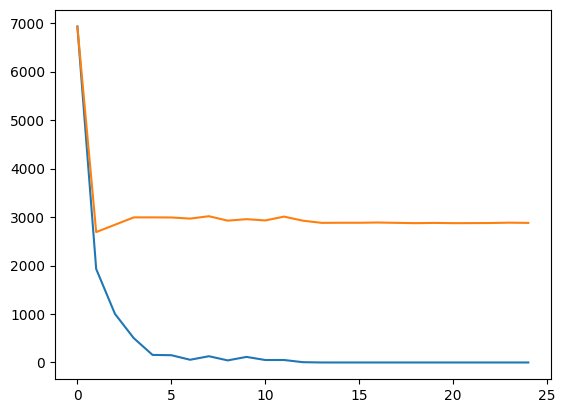

In [ ]:
executeTraining(d_model,num_layers,edgeMode=True)

Start
Model defined
Run name Att4Pairs_1726085276
0_-0.28969037959315236
Empirical error:_0.5173714285714286
Generalization error:_0.5148
100_-0.8383823467897323
Empirical error:_0.2141142857142857
Generalization error:_0.22685714285714287
200_-1.0010768949498425
Empirical error:_0.19142857142857142
Generalization error:_0.2234857142857143
300_-1.1290975415952866
Empirical error:_0.12851428571428572
Generalization error:_0.23114285714285715
400_-1.63178989326633
Empirical error:_0.08537142857142857
Generalization error:_0.2465142857142857
500_-1.9363056345981204
Empirical error:_0.0464
Generalization error:_0.25754285714285713
600_-2.1168424860279362
Empirical error:_0.06222857142857143
Generalization error:_0.2576
700_-2.081007358838972
Empirical error:_0.0296
Generalization error:_0.2576
800_-2.513409912748036
Empirical error:_0.03422857142857143
Generalization error:_0.26045714285714283
900_-3.413950657738224
Empirical error:_0.02154285714285714
Generalization error:_0.2579428571428

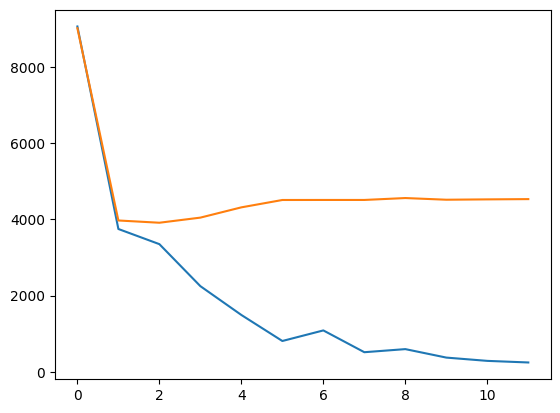

In [ ]:
executeTraining(d_model,num_layers,edgeMode=False)